In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from scipy import exp, sqrt, log, heaviside
from montecarlo import MC_Analisys,MC
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler

### Two equities

#### market data

In [2]:
N_equity = 2                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120])            #spot price of the two assets
corr = np.array(([1.,0.15],[0.15,1.]))        #correlation matrix

"""Market Discount factors"""
r_t = np.array([1.,0.9,1.2])/100            
T_discounts = np.array([0.1,1.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([1.2,3.,5.3,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = np.array([5.875,5.50,2.,2.3])/100  #market repo rates for equity 1
#repo_rate1 = np.array([10,10,10,10])/100
repo_rate1 = np.array([2,2,2,2])/100

T_repo2 = np.array([2.,3.,4.,T_max])
#repo_rate2 = np.array([2.,3.,3.034,2.99])/100
repo_rate2 = np.array([2,2,2,2])/100

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([25,25,25,25,25,25,25,25,25])/100
#sigma1 = np.array([32.2,29.3,29.1,29.5,29.7,29.8,29.9,30.6,30.62])/100
T_sigma1 = np.array([0.08,0.17,0.25,0.33,0.42,0.5,1.,2.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([25,25,25,25,25,25,25,25,25])/100
#sigma2 = np.array([35.,31.,31.,31.4,31.3,30.7,29.2,28.9,28.88])/100
T_sigma2 = np.array([0.08,0.17,0.27,0.37,0.44,0.5,1.,2.,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))      

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

#### Loading Discouting curve, Forward curve and forward variance matrix

In [3]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

Forward zero rate:  [0.01       0.00888889 0.01233333]
Forward volatility:  [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]
Forward volatility:  [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25]


In [4]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)

Drift time grid: [ 1.2  2.   3.   4.   5.3 10. ]
Drift values: [[0.02 0.02]
 [0.02 0.02]
 [0.02 0.02]
 [0.02 0.02]
 [0.02 0.02]
 [0.02 0.02]]
Cholesky covariance-variance time grid: [ 0.08  0.17  0.25  0.27  0.33  0.37  0.42  0.44  0.5   1.    2.   10.  ]
Cholesky covariance-variance matrix values: [[[0.25      0.25      0.25      0.25      0.25      0.25      0.25
   0.25      0.25      0.25      0.25      0.25     ]
  [0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.       ]]

 [[0.0375    0.0375    0.0375    0.0375    0.0375    0.0375    0.0375
   0.0375    0.0375    0.0375    0.0375    0.0375   ]
  [0.2471715 0.2471715 0.2471715 0.2471715 0.2471715 0.2471715 0.2471715
   0.2471715 0.2471715 0.2471715 0.2471715 0.2471715]]]


In [5]:
alpha = Strategy()
alpha.optimal(mu = mu, nu = nu,Ntrials = 1e6)

Optimal strategy time grid : [ 0.08  0.17  0.25  0.27  0.33  0.37  0.42  0.44  0.5   1.    1.2   2.
  3.    4.    5.3  10.  ]
Optimal strategy :  [[9.23068930e-07 9.99999077e-01]
 [9.99997919e-01 2.08134267e-06]
 [9.99998686e-01 1.31421633e-06]
 [9.99999517e-01 4.83061000e-07]
 [9.44493149e-07 9.99999056e-01]
 [1.07691048e-06 9.99998923e-01]
 [9.99999879e-01 1.21165217e-07]
 [4.78726963e-07 9.99999521e-01]
 [1.09896595e-06 9.99998901e-01]
 [6.54142659e-07 9.99999346e-01]
 [9.99999092e-01 9.08137490e-07]
 [9.99999061e-01 9.38875207e-07]
 [9.99999446e-01 5.54434495e-07]
 [9.99998697e-01 1.30287131e-06]
 [4.53404832e-06 9.99995466e-01]
 [9.99999726e-01 2.73639899e-07]]


In [6]:
I_0 = 1e5
vol = 0.25
n_dates = 40
dates = np.linspace(0,9,n_dates)
K = I_0
simulations = 2e5

In [7]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))

In [8]:
TVS = TargetVolatilityStrategy(forward_curve=TVSF)

In [9]:
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_optimal, result_err_optimal = MC_Analisys(pay,100)

### Random Strategy

In [10]:
np.random.seed(1)
strategy_times = alpha.T
strategy = np.random.uniform(0,1,(len(strategy_times),N_equity ))
norm = np.sum(strategy,axis=1)       #normalization
strategy = (strategy.T/norm).T   
print("Random Strategy")
print(strategy)
print(np.sum(strategy,axis=1))
bad_alpha = Strategy(strategy=strategy,dates=strategy_times)

Random Strategy
[[3.66662231e-01 6.33337769e-01]
 [3.78164892e-04 9.99621835e-01]
 [6.13798727e-01 3.86201273e-01]
 [3.50231061e-01 6.49768939e-01]
 [4.24085262e-01 5.75914738e-01]
 [3.79562835e-01 6.20437165e-01]
 [1.88858281e-01 8.11141719e-01]
 [3.92453864e-02 9.60754614e-01]
 [4.27568748e-01 5.72431252e-01]
 [4.14746642e-01 5.85253358e-01]
 [4.52652226e-01 5.47347774e-01]
 [3.11633286e-01 6.88366714e-01]
 [4.94856704e-01 5.05143296e-01]
 [6.85293315e-01 3.14706685e-01]
 [1.62056114e-01 8.37943886e-01]
 [1.89327153e-01 8.10672847e-01]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = bad_alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_bad, result_err_bad = MC_Analisys(pay,100)

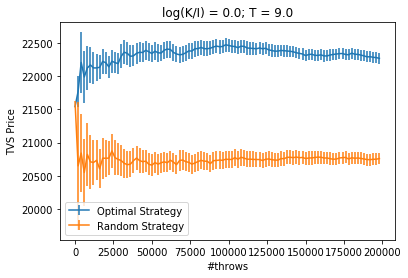

In [12]:
n =n_dates-1
plt.errorbar(x,result_optimal.T[n],yerr=result_err_optimal.T[n], label = "Optimal Strategy")
plt.errorbar(x,result_bad.T[n],yerr=result_err_bad.T[n], label = "Random Strategy")
plt.title("log(K/I) = "+str(round(log(K/I_0),2))+"; T = "+str(round(dates[n],2)))
plt.xlabel("#throws")
plt.ylabel("TVS Price")
plt.legend()
plt.show()

### Euler Method

TVS_euler = TargetVolatilityEuler(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))

n_dates_euler = 400
dates_euler = np.linspace(0,9,n_dates_euler)
I_t = TVS_euler.simulate(fixings = dates_euler,Nsim=5e5, seed=10)
pay_euler = Vanilla_PayOff(St=I_t,strike=K)*D(dates_euler)
price_euler,err_euler = MC(pay_euler)
x_euler, result_euler, result_err_euler = MC_Analisys(pay_euler,100)

plt.errorbar(dates_euler,price_euler,yerr=err_euler,label = "Euler method")
plt.errorbar(dates,price,yerr=err,label="GMB solution")
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("TVS price")

n = n_dates-1
plt.errorbar(x,result.T[n],yerr=result_err.T[n],label="GBM")
plt.title("log(K/I) = "+str(round(log(K/I_0),2))+"; T = "+str(round(dates[n],2)))
n = n_dates_euler-1
plt.errorbar(x_euler,result_euler.T[n],yerr=result_err_euler.T[n], label = "Euler method")
plt.xlabel("#throws")
plt.legend()
plt.ylabel("TVS Price")
plt.show()